## EDA - iDENTITY FEATURES

In [1]:
## Import Library 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# load merge data
DATA_DIR = Path('../data/interim')
train = pd.read_parquet(DATA_DIR / 'train_merged.parquet')

print(f'data loaded {train.shape[0]:,} row and {train.shape[1]:,} columns')

data loaded 590,540 row and 434 columns


In [2]:
train.columns.values

array(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
       'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14',
       'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1',
       'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29',
       'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38',
       'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47',
       'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56',
       'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65',
       'V66', 'V6

In [3]:
# identity coolumns
id_cols = [c for c in train.columns if c.startswith('id_')]
device_cols = ['DeviceType', 'DeviceInfo']

# check if any identity data exist per row
identity = train[id_cols + device_cols].notna().any(axis=1)

print('Identity Coverage')
print(f'Total Transacion : {len(train):,}')
print(f'   With identity: {identity.sum():,} ({identity.mean()*100:.1f}%)')
print(f'   Without identity: {(~identity).sum():,} ({(~identity).mean()*100:.1f}%)')

Identity Coverage
Total Transacion : 590,540
   With identity: 144,233 (24.4%)
   Without identity: 446,307 (75.6%)


Fraud Rate by identity presence
with identity : 7.85%
without identity : 2.09%


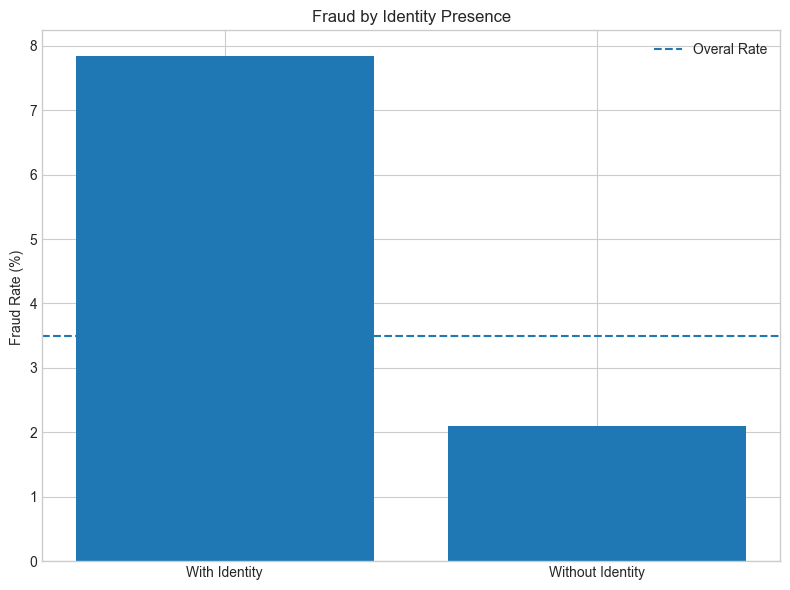

In [4]:
# fraud rate by identity presence

fraud_id = train.loc[identity, 'isFraud'].mean() * 100
fraud_without_id = train.loc[~identity, 'isFraud'].mean() * 100

print('Fraud Rate by identity presence')
print(f'with identity : {fraud_id:.2f}%')
print(f'without identity : {fraud_without_id:.2f}%')

# visualize 
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(['With Identity', 'Without Identity'], [fraud_id, fraud_without_id])
ax.set_ylabel('Fraud Rate (%) ')
ax.set_title('Fraud by Identity Presence')
ax.axhline(y=train['isFraud'].mean() * 100, linestyle='--', label='Overal Rate')
ax.legend()
plt.tight_layout()
plt.show()

## Device Feature 

In [5]:
## DEVICE TYPE
print('DeviceType Distribution :')
print(train['DeviceType'].value_counts(dropna=False))

# fraud by device type
device_fraud = train.groupby('DeviceType', dropna=False)['isFraud'].agg(['mean', 'count'])
device_fraud['mean'] *= 100

print('Fraud Rate by DeviceType:')
print(device_fraud)

DeviceType Distribution :
DeviceType
NaN        449730
desktop     85165
mobile      55645
Name: count, dtype: int64
Fraud Rate by DeviceType:
                 mean   count
DeviceType                   
desktop      6.521458   85165
mobile      10.166232   55645
NaN          2.101705  449730


top 15 device info
DeviceInfo
Windows                        47722
iOS Device                     19782
MacOS                          12573
Trident/7.0                     7440
rv:11.0                         1901
rv:57.0                          962
SM-J700M Build/MMB29K            549
SM-G610M Build/MMB29K            461
SM-G531H Build/LMY48B            410
rv:59.0                          362
SM-G935F Build/NRD90M            334
SM-G955U Build/NRD90M            328
SM-G532M Build/MMB29T            316
ALE-L23 Build/HuaweiALE-L23      312
SM-G950U Build/NRD90M            290
Name: count, dtype: int64


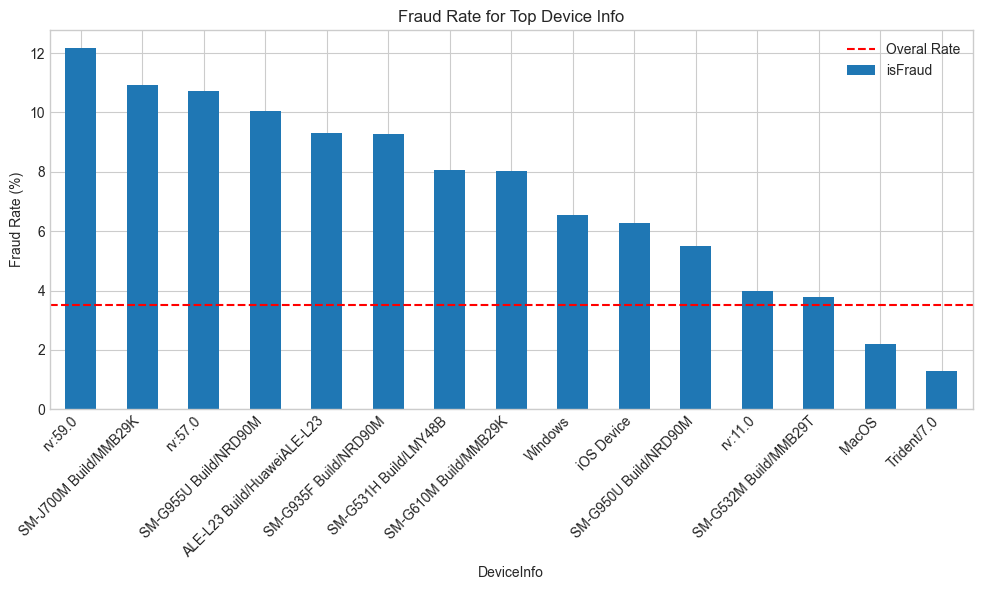

In [15]:
# device info 
#top device info 
top_device = train['DeviceInfo'].value_counts().head(15)

print('top 15 device info')
print(top_device)

# fraud rate for top device 
fraud_by_device = train.groupby('DeviceInfo')['isFraud'].mean() * 100
fraud_by_device = fraud_by_device.loc[top_device.index]

fig, ax = plt.subplots(figsize=(10,6))
fraud_by_device.sort_values(ascending=False).plot(kind='bar', ax=ax)
ax.set_title('Fraud Rate for Top Device Info')
ax.set_ylabel('Fraud Rate (%)')
ax.axhline(y=train['isFraud'].mean() * 100, color='red', linestyle='--', label='Overal Rate')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## ID FEAUTURE

In [21]:
id_cols = [f'id_{i:02d}' for i in range(1,39)]
id_cols = [c for c in id_cols if c in train.columns]

print(f'Id Feautures {len(id_cols)} columns')

# missing and unique 
id_stats = []
for col in id_cols:
    id_stats.append({
        'columns' : col,
        'missing_pct' : train[col].isnull().sum() / len(train) * 100,
        'nunique' : train[col].nunique(),
        'dtype' : str(train[col].dtype)
    })

id_df = pd.DataFrame(id_stats)
print(id_df.to_string())

Id Feautures 38 columns
   columns  missing_pct  nunique     dtype
0    id_01    75.576083       77   float32
1    id_02    76.145223   115655   float32
2    id_03    88.768923       24   float32
3    id_04    88.768923       15   float32
4    id_05    76.823755       93   float32
5    id_06    76.823755      101   float32
6    id_07    99.127070       84   float32
7    id_08    99.127070       94   float32
8    id_09    87.312290       46   float32
9    id_10    87.312290       62   float32
10   id_11    76.127273      365   float32
11   id_12    75.576083        2  category
12   id_13    78.440072       54   float32
13   id_14    86.445626       25   float32
14   id_15    76.126088        3  category
15   id_16    78.098012        2  category
16   id_17    76.399736      104   float32
17   id_18    92.360721       18   float32
18   id_19    76.408372      522   float32
19   id_20    76.418024      394   float32
20   id_21    99.126393      490   float32
21   id_22    99.124699       

id feautures correlations with isfraud :
id_01   -0.120099
id_07   -0.084768
id_04   -0.059701
id_08   -0.057489
id_19   -0.041721
id_06   -0.027139
id_13   -0.019538
id_05   -0.007978
id_24   -0.001905
id_11    0.007914
id_10    0.011043
id_09    0.029431
id_25    0.034045
id_03    0.041457
id_02    0.049398
id_18    0.050004
id_14    0.057324
id_20    0.061597
id_21    0.063544
id_32    0.069702
id_26    0.099587
id_22    0.118409
id_17    0.150100
Name: isFraud, dtype: float64


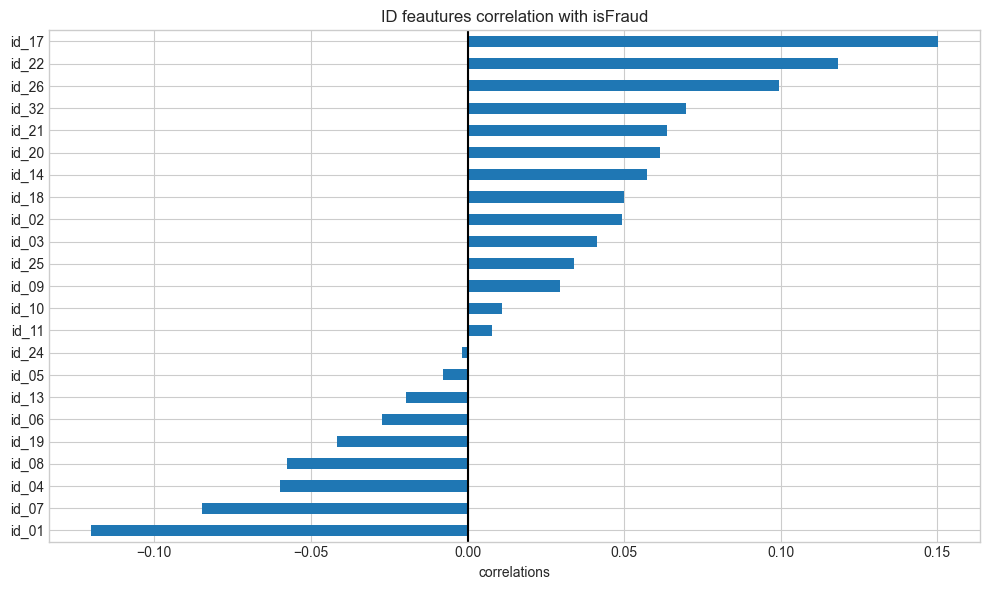

In [27]:
# correlations with fraud 

numeric_id_cols = train[id_cols].select_dtypes(include=[np.number]).columns.tolist()

if numeric_id_cols:
    id_corr = train[numeric_id_cols + ['isFraud']].corr()['isFraud'].drop('isFraud').sort_values()

    print('id feautures correlations with isfraud :')
    print(id_corr)

    fig, ax = plt.subplots(figsize=(10,6))
    id_corr.plot(kind='barh', ax = ax)
    ax.set_title('ID feautures correlation with isFraud')
    plt.xlabel('correlations')
    ax.axvline(x=0, color='black', linestyle='-')
    plt.tight_layout()
    plt.show()
    

- coverage : only ~ 33% have identity data 
- fraud pattern : fraud rate differs with/wtohout identity
- devicetype : desktop vs mobile might have different fraud rates
- device infp : some devices have higher fraud risk
- id features many are categorical with carying correlation